## Imports

In [37]:
# Python standard library
import os
import urllib

# Other third-party software
import numpy as np
import matplotlib.pyplot as plt

# Audio
#from audiolazy import str2midi # Apparently doesnt work in Python >3.6
from midiutil import MIDIFile

# Astropy
from astropy import coordinates as coord
from astropy import units as u
from astropy.table import Table

from astropy.visualization import make_lupton_rgb

from astroquery.skyview import SkyView

from astropy.io import fits
from astropy.utils.data import download_file

# Astroquery
import astroquery
from astroquery.simbad import Simbad
from astroquery.vo_conesearch import conf, conesearch, vos_catalog

# Targets

1. Wide-field infrared view of the Andromeda (M31) Galaxy using all four infrared detectors
    - RA: Approximately 00h 42m 44s
    - Dec: Approximately +41° 16' 09"

2. IC 342 - a normally obscured galaxy visible through infrared imaging
    - RA: Approximately 03h 46m 48s
    - Dec: Approximately +68° 05' 46"

3. WISE 0458+6434 - which is thought to consist of two T-class brown dwarfs
    - RA: Approximately 04h 58m 48s
    - Dec: Approximately +64° 34' 52"

4. The runaway star Zeta Ophiuchi and the bow shock formed by this massive star
    - RA: Approximately 16h 37m 09s
    - Dec: Approximately -10° 34' 01"

5. Puppis A, which is a supernova remnant
    - RA: Approximately 08h 24m 08s
    - Dec: Approximately -42° 59' 26"

6. The Rho Ophiuchi cloud complex
    - RA: - RA 16h 28m 6s
    - Dec -24° 32′ 30″

7. Lambda Centauri nebula (IC 2944), a star-forming region in the Milky Way
    - RA: 11h 36m 36.0s
    - Dec: −63° 02′ 00″

8. WISE data used to trace the Milky Way's spiral arms

9. X-shape of the Milky Way bulge revealed by WISE

10. WISE J224607.57-052635.0, the most luminous known galaxy in the Universe.
    - RA: Approximately 22h 46m 07.57s
    - Dec: Approximately -05° 26' 35.0"

# Data Acquisition

In [27]:
def fetch_wise_images(targets, output_root_directory, bands=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22']):
    """
    Fetches WISE survey images in FITS format for a list of targets and organizes them into separate folders.

    Parameters:
        targets (list of tuple): List of tuples, each containing the target name (str) and its coordinates (astropy.coordinates.SkyCoord).
        output_root_directory (str): Root directory where the downloaded FITS files and subfolders will be saved.
        bands (list of str): List of survey bands to fetch (e.g., ['WISE 3.4', 'WISE 4.6']).

    Returns:
        Dictionary containing target names as keys and lists of downloaded FITS file paths as values.
    """
    downloaded_files_by_target = {}
    
    # Create the output root directory if it doesn't exist
    if not os.path.exists(output_root_directory):
        os.makedirs(output_root_directory)

    for target_name, target_coordinates in targets:
        # Create a subdirectory for the target
        target_directory = os.path.join(output_root_directory, target_name)

        # Create the target's subdirectory if it doesn't exist
        if not os.path.exists(target_directory):
            os.makedirs(target_directory)

        # Fetch images from SkyView
        img_list = SkyView.get_images(position=target_coordinates, survey=bands)

        # Download and save the images for the target
        downloaded_files = []
        for i, img_info in enumerate(img_list):
            # Open header
            header = img_info[0].header
            
            # Extract coordinates from the header
            ra = header['CRVAL1']
            dec = header['CRVAL2']
            
            # Get the band from the list of bands and remove decimals
            band = bands[i].replace('WISE ', '').replace(' ', '').replace('.', '')
            
            # Convert coordinates to a suitable format for the file name
            ra_str = str(ra).replace('.', '').replace('-', '').replace(' ', '').zfill(8)
            dec_str = str(dec).replace('.', '').replace('-', '').replace(' ', '').zfill(7)
            
            # Construct the file name with coordinates
            filename = os.path.join(target_directory, f'WISE_J{ra_str}_{dec_str}_{band}.fits')
            #filename = os.path.join(target_directory, f'{survey_name}_{ra_str}_{dec_str}_{bands[i]}.fits')
            img_info[0].writeto(filename, overwrite=True)
            downloaded_files.append(filename)

        downloaded_files_by_target[target_name] = downloaded_files

    return downloaded_files_by_target

In [28]:
# List of targets with names and coordinates
targets = [
    ('M31', coord.SkyCoord.from_name('M31', frame='icrs')),
    ('IC 342', coord.SkyCoord.from_name('IC 342', frame='icrs'))
]

# Root directory where the downloaded FITS files and subfolders will be saved
root_output_dir = 'wise_images'

# Fetch WISE images for each target and organize them into subdirectories
downloaded_files_by_target = fetch_wise_images(targets, root_output_dir)

# Print the list of downloaded files for each target
for target_name, downloaded_files in downloaded_files_by_target.items():
    print(f"Downloaded FITS files for {target_name}:")
    for filename in downloaded_files:
        print(filename)

Downloaded FITS files for M31:
wise_images\M31\WISE_J00106847_0412688_34.fits
wise_images\M31\WISE_J00106847_0412688_46.fits
wise_images\M31\WISE_J00106847_0412688_12.fits
wise_images\M31\WISE_J00106847_0412688_22.fits
Downloaded FITS files for IC 342:
wise_images\IC 342\WISE_J00567022_0680961_34.fits
wise_images\IC 342\WISE_J00567022_0680961_46.fits
wise_images\IC 342\WISE_J00567022_0680961_12.fits
wise_images\IC 342\WISE_J00567022_0680961_22.fits


In [54]:
def open_fits_file(file_path):
    ''' Open FITS image file
    '''
    with fits.open(file_path) as hdu_list:
        data = hdu_list[0].data
    return data

In [55]:
def file_path_joiner(file_name, root_path):
    ''' Get file path of images to open
    '''
    relative_path = root_path + file_name
    file_path = os.path.join(os.getcwd(), relative_path)
    return file_path

In [29]:
relative_path = 'wise_images/M31/WISE_J00106847_0412688_12.fits'
image_file_path = os.path.join(os.getcwd(), relative_path)
#image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

In [56]:
image_file_path1 = file_path_joiner('WISE_J00106847_0412688_12.fits', 'wise_images/M31/')
image_file_path2 = file_path_joiner('WISE_J00106847_0412688_22.fits', 'wise_images/M31/')
image_file_path3 = file_path_joiner('WISE_J00106847_0412688_34.fits', 'wise_images/M31/')
image_file_path4 = file_path_joiner('WISE_J00106847_0412688_46.fits', 'wise_images/M31/')

In [62]:
image_data1 = open_fits_file(image_file_path1).astype(np.float64)
image_data2 = open_fits_file(image_file_path2).astype(np.float64)
image_data3 = open_fits_file(image_file_path3).astype(np.float64)
image_data4 = open_fits_file(image_file_path4).astype(np.float64)

print(image_data1.dtype, image_data2.dtype, image_data3.dtype, image_data4.dtype)
print(image_data1.shape, image_data2.shape, image_data3.shape, image_data4.shape)

print(np.min(image_data1), np.max(image_data1))
print(np.min(image_data2), np.max(image_data2))
print(np.min(image_data3), np.max(image_data3))
print(np.min(image_data4), np.max(image_data4))

image = make_lupton_rgb(image_file_path4, image_file_path3, image_file_path1)
plt.imshow(image, origin='lower')

float64 float64 float64 float64
(300, 300) (300, 300) (300, 300) (300, 300)
422.4393310546875 971.712890625
122.00837707519531 133.15476989746094
63.782958984375 3752.87353515625
32.889617919921875 1491.26611328125


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U101'), dtype('int32')) -> None

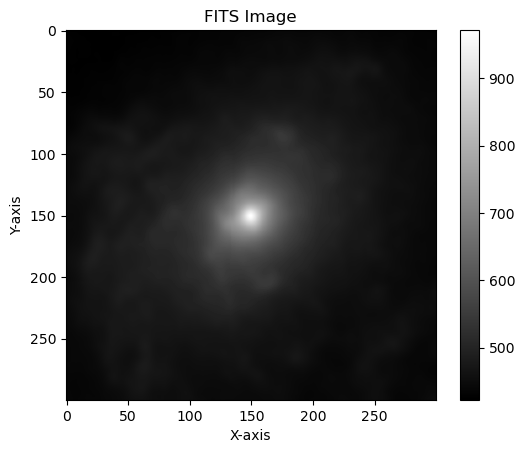

In [63]:
# Open the FITS file
hdu_list = fits.open(image_file_path1)

data = hdu_list[0].data

# Display image
plt.imshow(data, cmap='gray') #viridis
plt.colorbar()
plt.title('FITS Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

hdu_list.close()

# Sonificiation Algorithm

In [ ]:
def normalize_image_data(image_data):
    ''' Normalize the image data between 0 and 1.0
    '''
    return(image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

In [ ]:
def calculate_midi_pitch_range(octave_offset):
    """
    Calculate the MIDI pitch range based on the given octave offset.
    
    Parameters:
        octave_offset (int): The octave offset value (e.g., 0 for the default octave).
    
    Returns:
        tuple: A tuple containing the minimum and maximum MIDI pitches for the specified octave.
    """
    # Define the number of semitones in an octave
    semitones_per_octave = 12

    # Calculate the MIDI pitch for the minimum note of the specified octave
    min_pitch = octave_offset * semitones_per_octave

    # Calculate the MIDI pitch for the maximum note of the specified octave
    max_pitch = min_pitch + semitones_per_octave - 1

    return min_pitch, max_pitch

In [ ]:
def map_brightness_to_pitch_and_velocity(brightness, min_pitch = 60, max_pitch = 72):
    ''' Define a mapping function for brightness to pitch and velocity
    '''
    # Define the range for mapping brightness to pitch (e.g., from C4 to C6)
    pitch_range = [min_pitch, max_pitch]  # MIDI note numbers

    # Map brightness to pitch within the defined range
    pitch = int(np.interp(brightness, [0, 1], pitch_range))

    # Map brightness to velocity (e.g., linear mapping)
    velocity = int(np.interp(brightness, [0, 1], [40, 127]))

    return pitch, velocity

In [ ]:
def create_image_sonification(normalized_data, bpm = 60):
    '''
    '''
    
    # Assumes all images are same size
    num_rows, num_cols = normalized_data[0].shape
    
    #duration_beats = 52.8 # desired duration in beats (1 beat = 1 second if bpm=60)
    bpm = 60 # Tempo in beats per minute (BPM)
    duration_per_pixel = 0.1

    #y_scale = 0.5  #scaling parameter for y-axis data (1 = linear)

    # Note set for mapping (or use a few octaves of a specific scale)
    #note_names = ['C1','C2','G2',
    #             'C3','E3','G3','A3','B3',
    #             'D4','E4','G4','A4','B4',
    #             'D5','E5','G5','A5','B5',
    #             'D6','E6','F#6','G6','A6']
    
    #note_names = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']
    
    #vel_min, vel_max = 35, 127   # define minimum and maximum note velocity
    
    # Define octave offsets for each frequency band
    #octave_offsets = [0, 12, 24, 36]
    octave_offsets = [i for i in range(0, len(normalized_data))]
    
    ## Calculate duration in seconds
    #duration_sec = max(t_data)*60/bpm # duration in seconds (actually, onset of last note)
    
    # Create a MIDI file
    midi_file = MIDIFile(1)
    midi_file.addTempo(0, 0, bpm)
    
    ## Map image data to MIDI notes and velocity
    for band_index, img_data in enumerate(normalized_data):
        for i in range(num_rows):
            for j in range(num_cols):
                
                # Get pixel value
                brightness = img_data[row, col]

                # Map brightness value to note names and octave
                #note_name, octave = map_pixel_to_note_name_and_octave(brightness, octave_offsets[band_index])
                #note_name, octave = map_pixel_to_note_name_and_octave(pixel_value_band1, octave_offsets[band_index])
                
                # Compute midi pitch range
                min_pitch, max_pitch = calculate_midi_pitch_range(octave_offset[band_index])
                
                # Map brightness to pitch and velocity
                pitch, velocity = map_brightness_to_pitch_and_velocity(
                    brightness, min_pitch, max_pitch
                )

                # Convert note names to midi pitch
                #pitch = str2midi(f"{note_name}{octave}")

                # Velocity
                #velocity = int(127 * pixel_value)
                #velocity = scale_midi_velocity(int(127 * pixel_value), vel_min, vel_max)
                #velolcity_mapped = scale_midi_velocity(velocity, min_velocity, max_velocity)

                # Layer the notes from different bands together at the same time point
                time_point = col

                midi_file.addNote(
                    0,  # Track number
                    0,  # Channel number
                    pitch,
                    time_point,
                    int(duration_per_pixel), # note duration
                    velocity
                )
            
    # Save the MIDI file
    with open(output_file, "wb") as file:
        midi_file.writeFile(file)
    
    print(f"Saved: {output_file}")

In [ ]:
image_file_path1 = file_path_joiner('WISE_J00106847_0412688_12.fits', 'wise_images/M31/')
image_file_path2 = file_path_joiner('WISE_J00106847_0412688_22.fits', 'wise_images/M31/')
image_file_path3 = file_path_joiner('WISE_J00106847_0412688_34.fits', 'wise_images/M31/')
image_file_path4 = file_path_joiner('WISE_J00106847_0412688_46.fits', 'wise_images/M31/')

image_data1 = open_fits_file(image_file_path1)
image_data2 = open_fits_file(image_file_path2)
image_data3 = open_fits_file(image_file_path3)
image_data4 = open_fits_file(image_file_path4)

In [ ]:
normalized_data = [normalize_image_data(image_data1), 
                   normalize_image_data(image_data2), 
                   normalize_image_data(image_data3), 
                   normalize_image_data(image_data4)]

# Temp Junk Code

In [ ]:
def map_value(value,min_value,max_value,min_result,max_result):
    '''maps value (or array of values) from one range to another'''
    result = min_result + (value - min_value)/(max_value-min_value)*(max_result - min_result)
    return result

In [ ]:
duration_beats = 52.8 # desired duration in beats (1 beat = 1 second if bpm=60)
bpm = 60 # tempo in beats per minute (BPM)

y_scale = 0.5  #scaling parameter for y-axis data (1 = linear)

#note set for mapping (or use a few octaves of a specific scale)
note_names = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

vel_min,vel_max = 35,127   #minimum and maximum note velocity

In [ ]:
## Load data
df = pd.read_csv('./data/' +filename + '.csv')  #load data as a pandas dataframe
n_impacts = len(df)

ages = df['age'].values    #this is a numpy array (not a list), you can do mathematical operations directly on the object
diameters = df['diameter'].values

## Compress Time
t_data = map_value(ages, min(ages), max(ages), duration_beats, 0) #compress time from Myrs to beats, largest age (oldest crater) mapped to beat 0

## Calculate duration in seconds
duration_sec = max(t_data)*60/bpm #duration in seconds (actually, onset of last note)
print('Duration:',duration_sec,'seconds')

## Normalize and scale y-axis data
y_data = map_value(diameters, min(diameters), max(diameters), 0, 1) #normalize data, so it runs from 0 to 1 (makes scaling easier)
y_data = y_data**y_scale

## Make list of MIDI numbers of chosen notes for mapping
note_midis = [str2midi(n) for n in note_names] #make a list of midi note numbers
n_notes = len(note_midis)
print('Resolution:',n_notes,'notes')

## Map y-axis data to MIDI notes and velocity
midi_data = []
vel_data = []
for i in range(n_impacts):
    note_index = round(map_value(y_data[i], 0, 1, n_notes-1, 0)) #bigger craters are mapped to lower notes
    midi_data.append(note_midis[note_index])

    note_velocity = round(map_value(y_data[i], 0, 1, vel_min, vel_max)) #bigger craters will be louder
    vel_data.append(note_velocity)

## Save MIDI file
my_midi_file = MIDIFile(1) #one track
my_midi_file.addTempo(track=0, time=0, tempo=bpm)

for i in range(n_impacts):
    my_midi_file.addNote(track=0, channel=0, pitch=midi_data[i], time=t_data[i] , duration=2, volume=vel_data[i])

with open(filename + '.mid', "wb") as f:
    my_midi_file.writeFile(f)
print('Saved',filename + '.mid')

In [ ]:
# Define MIDI parameters
output_file = "galaxy_sonification.mid"
num_rows, num_cols = image_data.shape
bpm = 120
duration_per_pixel = 0.1  # Adjust as needed

In [ ]:
def scale_midi_velocity(velocity, min_velocity, max_velocity):
    """
    Scale MIDI note velocity from its original range (0-127) to a new range specified by min_velocity and max_velocity.
    
    Parameters:
        velocity (int): The original MIDI velocity value (0-127).
        min_velocity (int): The minimum value for the new range.
        max_velocity (int): The maximum value for the new range.
    
    Returns:
        int: The scaled velocity value within the new range.
    """
    # Ensure that the velocity is within the MIDI velocity range (0-127)
    velocity = max(0, min(127, velocity))
    
    # Scale the velocity to the new range
    scaled_velocity = min_velocity + (velocity / 127) * (max_velocity - min_velocity)
    
    return int(scaled_velocity)

In [ ]:
# Normalize image data to fit pitch range
normalized_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
pitch_range = np.linspace(min_pitch, max_pitch, num=num_rows)

# Create MIDI notes based on image data
for row in range(num_rows):
    for col in range(num_cols):
        pixel_value = normalized_data[row, col]
        pitch = int(pitch_range[row])
        duration = int(duration_per_pixel)
        velocity = int(127 * pixel_value)

        midi_file.addNote(
            0,  # Track number
            0,  # Channel number
            pitch,
            col,  # Time (adjust as needed)
            duration,
            velocity
        )

In [ ]:
def create_image_sonification(normalized_data):
    '''
    '''
    normalized_data_band1 = normalized_data[0]
    normalized_data_band2 = normalized_data[1]
    normalized_data_band3 = normalized_data[2]
    
    duration_beats = 52.8 # desired duration in beats (1 beat = 1 second if bpm=60)
    bpm = 60 # tempo in beats per minute (BPM)

    y_scale = 0.5  #scaling parameter for y-axis data (1 = linear)

    #note set for mapping (or use a few octaves of a specific scale)
    note_names = ['C1','C2','G2',
                 'C3','E3','G3','A3','B3',
                 'D4','E4','G4','A4','B4',
                 'D5','E5','G5','A5','B5',
                 'D6','E6','F#6','G6','A6']
    
    note_names = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']
    
    vel_min,vel_max = 35,127   #minimum and maximum note velocity
    
    ## Calculate duration in seconds
    duration_sec = max(t_data)*60/bpm #duration in seconds (actually, onset of last note)
    
    duration_per_pixel = 0.1  # Adjust as needed
    
    
    # Create a MIDI file
    midi_file = MIDIFile(1)
    midi_file.addTempo(0, 0, bpm)
    
    ## Map image data to MIDI notes and velocity
    #midi_data = []
    #vel_data = []
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            pixel_value = normalized_data[row, col]
            note_name = map_pixel_to_note_name(pixel_value)
            pitch = str2midi(note_name)
            #pitch = int(pitch_range[row])
            duration = int(duration_per_pixel)
            
            velocity = int(127 * pixel_value)
            #vel_data.append(note_velocity)
            
            #note_index = round(map_value(y_data[i], 0, 1, n_notes-1, 0)) #bigger craters are mapped to lower notes
            #midi_data.append(note_midis[note_index])

            #note_velocity = round(map_value(y_data[i], 0, 1, vel_min, vel_max)) #bigger craters will be louder
            #vel_data.append(note_velocity)
            
            midi_file.addNote(
            0,  # Track number
            0,  # Channel number
            pitch,
            col,  # Time (adjust as needed)
            duration,
            velocity
            )

    # Save the MIDI file
    with open(output_file, "wb") as file:
        midi_file.writeFile(file)
    
    print(f"Saved: {output_file}")

In [ ]:
c = coord.SkyCoord.from_name('M31', frame='icrs') # Anrdomeda
#c = coord.SkyCoord.from_name('IC 342', frame='icrs')
print(c)

In [ ]:
from astroquery.skyview import SkyView
#SkyView.get_image_list(position='Eta Carinae', survey=['Fermi 5', 'HRI', 'DSS'])
img_list = SkyView.get_image_list(position=c, survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'])
#'IR:WISE': ['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'],
img_list

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Define the coordinates of WISE J224607.57-052635.0
ra = "22h46m07.57s"
dec = "-05d26m35.0s"

# Create a SkyCoord object
wise_coords = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

# Print the coordinates
print(wise_coords)


In [11]:
def fetch_wise_images(coordinates, output_root_directory, bands=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22']):
    """
    Fetches WISE survey images for a given set of coordinates.

    Parameters:
        coordinates (astropy.coordinates.SkyCoord): Coordinates of the target.
        output_root_directory (str): Directory where the downloaded FITS files will be saved.
        bands (list of str): List of survey bands to fetch (e.g., ['WISE 3.4', 'WISE 4.6']).

    Returns:
        List of downloaded FITS file paths.
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_root_directory):
        os.makedirs(output_root_directory)

    # Fetch images from SkyView
    img_list = SkyView.get_images(position=coordinates, survey=bands)
    print(img_list)

    # Download and save the images
    downloaded_files = []
    for i, img_info in enumerate(img_list):
        
        # Extract inforamtion from the header
        header = img_info[0].header
        survey_name = img_info[0].header['SURVEY']
        ra = header['CRVAL1']
        dec = header['CRVAL2']
        
        # Convert coordinates to a suitable format for the file name
        ra_str = str(ra).replace('.', 'p').replace('-', 'm')
        dec_str = str(dec).replace('.', 'p').replace('-', 'm')
        
        filename = os.path.join(output_directory, f'{survey_name}_{ra_str}_{dec_str}_{bands[i]}.fits')
        img_info[0].writeto(filename, overwrite=True)
        downloaded_files.append(filename)

    return downloaded_files

In [10]:
# Example coordinates for Andromeda (M31)
obj_name = 'M31'
m31_coords = coord.SkyCoord.from_name(obj_name, frame = 'icrs')

# Directory where the downloaded FITS files will be saved
output_dir = 'wise_images'


# Fetch WISE images for M31 in the specified bands
downloaded_files = fetch_wise_images(m31_coords, output_dir)

# Print the list of downloaded files
print("Downloaded FITS files:")
for filename in downloaded_files:
    print(filename)

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000264B6687790>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000264B66ACF40>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000264B66AE6B0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000264B66AFE20>]]
Downloaded FITS files:
wise_images\WISE_WISE 3.4.fits
wise_images\WISE_WISE 4.6.fits
wise_images\WISE_WISE 12.fits
wise_images\WISE_WISE 22.fits


In [ ]:
def create_image_sonification(normalized_data, bpm = 60):
    '''
    '''
    
    num_rows, num_cols = normalized_data[0].shape
    
    #duration_beats = 52.8 # desired duration in beats (1 beat = 1 second if bpm=60)
    #bpm = 60 # Tempo in beats per minute (BPM)

    #y_scale = 0.5  #scaling parameter for y-axis data (1 = linear)

    # Note set for mapping (or use a few octaves of a specific scale)
    note_names = ['C1','C2','G2',
                 'C3','E3','G3','A3','B3',
                 'D4','E4','G4','A4','B4',
                 'D5','E5','G5','A5','B5',
                 'D6','E6','F#6','G6','A6']
    
    note_names = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']
    
    vel_min, vel_max = 35, 127   # define minimum and maximum note velocity
    
    ## Calculate duration in seconds
    #duration_sec = max(t_data)*60/bpm # duration in seconds (actually, onset of last note)
    
    duration_per_pixel = 0.1
    
    # Create a MIDI file
    midi_file = MIDIFile(1)
    midi_file.addTempo(0, 0, bpm)
    
    ## Map image data to MIDI notes and velocity
    for band_index, img_data in enumerate(normalized_data):
        for i in range(num_rows):
            for j in range(num_cols):
                
                # Get pixel value
                pixel_value = img_data[row, col]

                # Map pixel value to note names and octave
                note_name, octave = map_pixel_to_note_name_and_octave(pixel_value_band1, octave_offsets[band_index])

                # Convert note names to midi pitch
                pitch = str2midi(f"{note_name}{octave}")

                # Velocity
                #velocity = int(127 * pixel_value)
                velocity = scale_midi_velocity(int(127 * pixel_value), vel_min, vel_max)
                #velolcity_mapped = scale_midi_velocity(velocity, min_velocity, max_velocity)

                # Layer the notes from different bands together at the same time point
                time_point = col

                midi_file.addNote(
                    0,  # Track number
                    0,  # Channel number
                    pitch,
                    time_point,
                    int(duration_per_pixel), # note duration
                    velocity
                )
            
    # Save the MIDI file
    with open(output_file, "wb") as file:
        midi_file.writeFile(file)
    
    print(f"Saved: {output_file}")

In [ ]:
def compute_pitch_range_for_octaves(midi_pitch):
    """
    Compute the MIDI pitch range for one octave above and one octave below the given MIDI pitch.
    
    Parameters:
        midi_pitch (int): The current MIDI pitch.
    
    Returns:
        tuple: A tuple containing the MIDI pitch range (min_pitch, max_pitch) for one octave above and below.
    """
    # Define the number of semitones in an octave
    semitones_per_octave = 12

    # Calculate the MIDI pitch for one octave above and below
    pitch_octave_above = midi_pitch + semitones_per_octave
    pitch_octave_below = midi_pitch - semitones_per_octave

    # Define the range for one octave above and below
    min_pitch = min(pitch_octave_above, pitch_octave_below)
    max_pitch = max(pitch_octave_above, pitch_octave_below)

    return min_pitch, max_pitch

In [ ]:
def map_pixel_to_note_name_and_octave(pixel_value, octave_offset):
    ''' Maps each pixel to a midi note name and octave
    '''
    # Calculate the index based on the normalized pixel value
    index = int(np.interp(pixel_value, [0, 1], [0, len(note_names) - 1]))
    note_name = note_names[index]
    
    # Calculate the octave based on the octave offset
    octave = octave_offset
    return note_name, octave

In [ ]:
def map_pixel_to_note_name(pixel_value):
    ''' Define a mapping function for pixel values to note names
    '''
    # Calculate the index based on the normalized pixel value
    index = int(np.interp(pixel_value, [0, 1], [0, len(note_names) - 1]))
    return note_names[index]

In [ ]:
def map_pixel_to_pitch(pixel_value):
    ''' Define a mapping function for pixel values to pitch
    '''
    pitch = int(np.interp(pixel_value, [0, 255], [min_pitch, max_pitch]))
    return pitch

In [ ]:
def map_pitch_to_note_name(pitch):
    """
    Map a MIDI pitch value to a note name with octave.
    
    Parameters:
        pitch (int): The MIDI pitch value.
    
    Returns:
        str: The note name with octave (e.g., "C4").
    """
    # Define the note names (chromatic scale)
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Calculate the note index (0-11) within the chromatic scale
    note_index = pitch % 12

    # Calculate the octave (e.g., C4, C5, etc.)
    octave = (pitch // 12) - 1  # Subtract 1 because MIDI octave starts from -1

    # Construct the note name with octave
    note_name_with_octave = f"{note_names[note_index]}{octave}"

    return note_name_with_octave

In [ ]:
def map_brightness_to_pitch_and_velocity(brightness, min_brightness, max_brightness, min_pitch, max_pitch, min_velocity, max_velocity):
    """
    Map pixel brightness to MIDI pitch and velocity based on specified ranges.
    
    Parameters:
        brightness (float): The pixel brightness value (between min_brightness and max_brightness).
        min_brightness (float): The minimum brightness value in the image.
        max_brightness (float): The maximum brightness value in the image.
        min_pitch (int): The minimum MIDI pitch value (e.g., C4).
        max_pitch (int): The maximum MIDI pitch value (e.g., C6).
        min_velocity (int): The minimum MIDI velocity value (0-127).
        max_velocity (int): The maximum MIDI velocity value (0-127).
    
    Returns:
        tuple: A tuple containing the mapped pitch and velocity.
    """
    # Map brightness to pitch within the specified range
    pitch = int(np.interp(brightness, [min_brightness, max_brightness], [min_pitch, max_pitch]))

    # Map brightness to velocity within the specified range
    velocity = int(np.interp(brightness, [min_brightness, max_brightness], [min_velocity, max_velocity]))

    return pitch, velocity

In [ ]:
def str2midi(note_str):
    note_mapping = {
        'C': 60, 'C#': 61, 'D': 62, 'D#': 63, 'E': 64, 'F': 65,
        'F#': 66, 'G': 67, 'G#': 68, 'A': 69, 'A#': 70, 'B': 71
    }

    # Extract the note name and octave from the note string
    note_name = note_str[:-1]
    octave = int(note_str[-1])

    # Calculate the MIDI note number
    midi_note = note_mapping.get(note_name.upper())

    if midi_note is not None:
        # Add the octave offset (assuming MIDI octave 4 = middle C)
        midi_note += (octave - 4) * 12

    return midi_note